In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import sys,os,cv2, scipy
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.optimize import curve_fit
from scipy import signal
from scipy.interpolate import griddata
from skimage.morphology import skeletonize
sys.path.append("/Users/kai/Downloads/graduation/final_git/MasterThesis/src/")
from config import *
from make_dataset import *
sys.path.append(AMFTracker_path)
from amftrack.util.sys import storage_path,temp_path
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
    remove_component, 
    remove_holes,
    run_back_sub,
    bowler_hat,
)

/Users/kai/Downloads/graduation/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
select_exp = labelme_path+"Fluorescence_ex_Kai-kai_Plate705.xlsx"
exp_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="11.16",skiprows=1,index_col=0,header=0)
segment = get_labelme_segments(labelme_path + "20221116_Plate705/")
width_dict,width_std_dict= compute_width_from_segment(segment)
labelme_df = pd.DataFrame.from_dict(width_dict,orient='index')
labelme_df = labelme_df.sort_index()
for index, value in labelme_df.iterrows():
    if len(index.split("_")) == 2:
        pos, direction = index.split("_")
        exp_df.at[pos.lower(),direction]=value[0]
    if len(index.split("_")) == 3:
        pos, direction,direction2 = index.split("_")
        exp_df.at[pos.lower(),direction+direction2]=value[0]
exp_df = exp_df.iloc[:,9:]
exp_df["new_index"] = exp_df.index
exp_df["new_index"] = np.where(exp_df["new_index"].str.len() <=4, exp_df["new_index"].str.slice(stop=3)+"0"+exp_df["new_index"].str.slice(start=3), exp_df["new_index"])
exp_df = exp_df.set_index("new_index")
exp_df

,D,R,top,L,D1,D2,middle,middle2,middle3,focus1D,...,middle D2,R2,down,Ltop,LD,Lmiddle,Lmiddle2,Rtop,middleD,middletop
new_index,,,,,,,,,,,,,,,,,,,,,
pos01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.335141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos02,5.096730,4.853125,NaN,4.481460,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos03,NaN,3.360181,5.466252,3.329234,NaN,NaN,6.101661,5.704716,NaN,NaN,...,NaN,NaN,5.97832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos04,4.738162,NaN,3.890178,NaN,NaN,NaN,4.940548,4.970713,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos05,4.811456,2.815162,3.867490,3.271058,NaN,NaN,4.886012,4.084507,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pos60,6.794172,7.723462,8.546125,5.528969,NaN,NaN,8.260645,7.327132,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos61,NaN,3.494587,NaN,3.295571,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.635567,NaN,NaN,NaN,2.356413,2.938713,2.809692
pos62,NaN,4.441835,3.247844,4.304565,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
select_exp = labelme_path+"Fluorescence_ex_Kai-kai_Plate705.xlsx"
ML_df = pd.read_excel(select_exp,engine = "openpyxl",sheet_name="50X_ML",index_col=0,header=0)
ML_df

,edges,labelme_label,order_1,order_2,order_3,order_4
pos,,,,,,
pos02,"[(0, 4), (4, 2), (4, 5)]",DRL,L,R,D,NaN
pos06,"[(2, 7), (7, 16), (7, 19)]",DRtop,top,D,R,NaN
pos07,"[(0, 4), (4, 2), (4, 5)]",DRtop,top,R,D,NaN
pos08,"[(3, 8), (8, 9), (8, 6)]",DtopL,top,D,L,NaN
pos09,"[(4, 6), (3, 6), (6, 7)]",DRtop,top,R,D,NaN
pos10,"[(0, 4), (4, 2), (4, 5)]",DRtop,top,R,D,NaN
pos11,"[(0, 10), (10, 11), (10, 2)]",DRtop,top,D,R,NaN
pos12,"[(0, 8), (8, 2), (8, 9)]",DRtop,top,R,D,NaN
pos13,"[(2, 7), (7, 17), (7, 12)]",DRtop,top,D,R,NaN


In [15]:
images_path = r"/run/user/357100579/gvfs/smb-share:server=sun.amolf.nl,share=shimizu-data/home-folder/Kaikai/Plate705_161122"
binning = 1
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path,file) for file in files]
selection_file = images_total_path
selection_file.sort()

In [5]:
# test for all
collect_slice = []
collect_labels = []
order_label = ["order_1","order_2","order_3","order_4"]
check =[]
for begin in range(len(selection_file)):
    file_name = selection_file[begin].split('/')[-1].split('.')[0]
    try:
        row = exp_df.loc[file_name].dropna()
        if len(row) <= 3:
            print(f'{file_name} is loading.')
            image = imageio.imread(selection_file[begin])
            segmented, nx_graph_pruned, pos = segment_brightfield(image)
            edges = list(nx_graph_pruned.edges)
            bound1 = 0
            bound2 = 1
            offset=100
            step=30
            target_length=200
            resolution = 1
            weight = 0.15
            count = -1
            #for plot
            for edge in edges:
                if count < 3:
                    count+=1
                try:
                    position = ML_df.loc[file_name][order_label[count]]
                    width = exp_df.loc[file_name][position]
                    slices, segments = extract_section_profiles_for_edge(
                        edge,
                        pos,
                        image,
                        nx_graph_pruned,
                        resolution=resolution,
                        offset=offset,
                        step=step,
                        target_length=target_length,
                        bound1=bound1,
                        bound2=bound2)
                    check.append(len(slices))
                    # for dataset                    
                    collect_slice.extend(slices)
                    collect_labels.extend(len(slices)*[width])
                except KeyError:
                    print(f'{file_name} {order_label[count]} cannot find')
                    continue
    except KeyError:
        print(f'The file {file_name} will not be extract.')

The file pos01_focus1 will not be extract.
The file pos01_focus2 will not be extract.
The file pos01_focus3 will not be extract.
pos02 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos06 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos07 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos08 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos09 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos10 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos11 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos12 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos13 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos14 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos14 order_4 cannot find
pos15 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos16 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos17 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos19 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos22 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos24 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos25 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos28 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos29 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos29 order_4 cannot find
pos31 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos32 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos33 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos33 order_2 cannot find
pos36 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos37 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos38 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos38 order_1 cannot find
pos42 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos42 order_4 cannot find
pos45 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos46 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos46 order_4 cannot find
pos47 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos49 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos50 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos51 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos53 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos54 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos55 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos56 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos57 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos58 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos62 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos63 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos64 is loading.


/tmp/ipykernel_4024915/963466958.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[begin])
/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


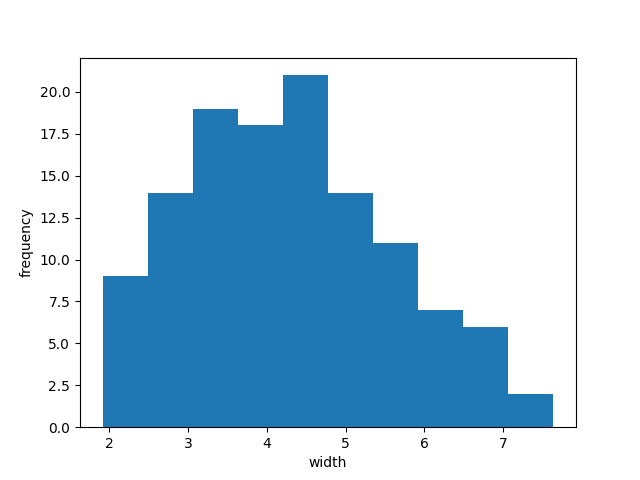

In [36]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.hist(collect_labels,bins=10)
plt.xlabel("width")
plt.ylabel("frequency")
plt.show()

In [ ]:
# test for all
collect_slice = []
collect_labels = []
order_label = ["order_1","order_2","order_3","order_4"]
for begin in range(len(selection_file)):
    file_name = selection_file[begin].split('/')[-1].split('.')[0]
    try:
        row = exp_df.loc[file_name].dropna()
        if len(row) <= 3:
            print(f'{file_name} is loading.')
            image = imageio.imread(selection_file[begin])
            segmented, nx_graph_pruned, pos = segment_brightfield(image)
            edges = list(nx_graph_pruned.edges)
            bound1 = 0
            bound2 = 1
            offset=100
            step=30
            target_length=200
            resolution = 1
            weight = 0.15
            count = -1
            for edge in edges:
                if count < 3:
                    count+=1
                try:
                    position = ML_df.loc[file_name][order_label[count]]
                    width = exp_df.loc[file_name][position]
                    slices, segments = extract_section_profiles_for_edge(
                        edge,
                        pos,
                        image,
                        nx_graph_pruned,
                        resolution=resolution,
                        offset=offset,
                        step=step,
                        target_length=target_length,
                        bound1=bound1,
                        bound2=bound2)
                    # for dataset                    
                    collect_slice.append(slices)
                    collect_labels.append(len(slices)*[width])
                except KeyError:
                    print(f'{file_name} {order_label[count]} cannot find')
                    continue
    except KeyError:
        print(f'The file {file_name} will not be extract.')

The file  will not be extract.
The file pos01_focus1 will not be extract.
The file pos01_focus1 will not be extract.
The file pos01_focus2 will not be extract.
The file pos01_focus2 will not be extract.
The file pos01_focus3 will not be extract.
The file pos01_focus3 will not be extract.
pos02 is loading.


ValueError: Could not find a backend to open `/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/Experiment/Labelme/Plate705_20221116/pos02.json`` with iomode `ri`.

In [76]:
check_slice=[]
check_labels = []
for i in collect_slice:
    check_slice.extend(i[::len(i)//10])
for i in collect_labels:
    check_labels.extend(i[::len(i)//10])

2022-12-21 16:56:51,858-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


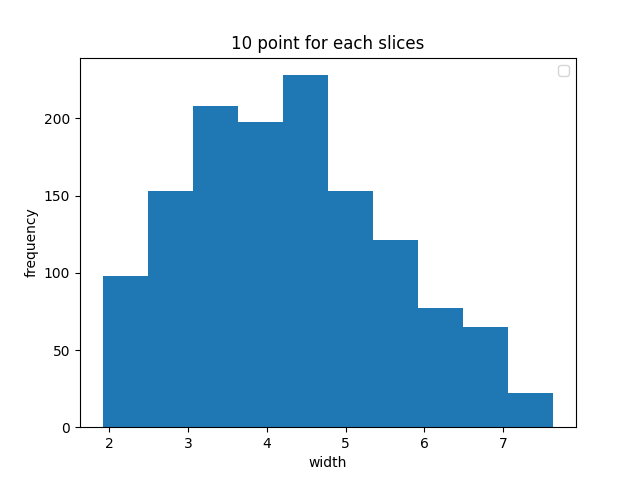

In [79]:
check_labels = []
for i in collect_labels:
    check_labels.extend(i[::len(i)//10])
%matplotlib widget
import matplotlib.pyplot as plt
plt.hist(check_labels,bins=10)
plt.title("10 point for each slices")
plt.xlabel("width")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [80]:
slice_array = np.array(check_slice)
label_array = np.array(check_labels)
print(f"Slice array: {slice_array.shape} Label array: {label_array.shape}")

Slice array: (1323, 200) Label array: (1323,)


In [82]:
os.mkdir(os.path.join(dataset_path, "50X_groundtruth_dataset_10point_each_segment"))
cv2.imwrite(os.path.join(dataset_path, "50X_groundtruth_dataset_10point_each_segment","slices.png"), slice_array)
with open(os.path.join(dataset_path, "50X_groundtruth_dataset_10point_each_segment","labels.npy"), "wb") as f:
    np.save(f, label_array)
with open(os.path.join(dataset_path, "50X_groundtruth_dataset_10point_each_segment","info.txt"), "w") as f:
    f.write(f"Slice array: {slice_array.shape} Label array: {label_array.shape}")
    f.write('\nPlate number 705\nStrain: C2\nCrossdate: 10/14\nPrince position: 21\nPRINCE FULL DATA: 20221116_0311_Plate21')
    f.write('\nThis dataset get 10 points from each segment')

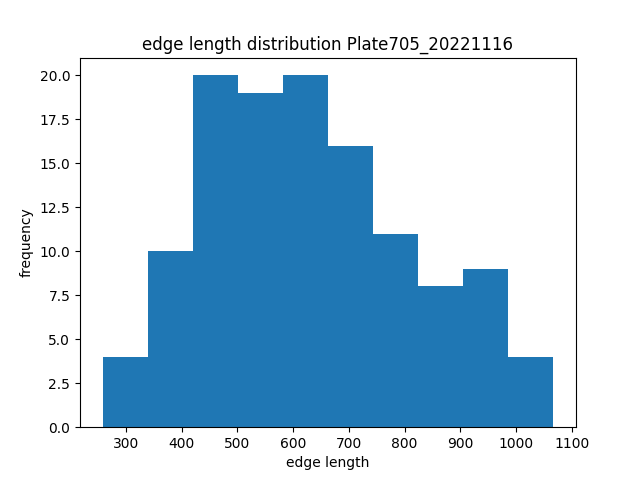

In [49]:
check=[]
for i in collect_slice:
    check.append(len(i))
%matplotlib widget
import matplotlib.pyplot as plt
plt.hist(check,bins=10)
plt.xlabel("edge length")
plt.ylabel("frequency")
plt.title("edge length distribution Plate705_20221116")
plt.savefig("plot_data/GroundTruthML/edge length distribution Plate705_20221116.png")

In [208]:
import tensorflow as tf
import sys, imageio, os
sys.path.append("/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/")
# from config import *
from models.data_prepare import *
from models.model import *
import keras
X, y=data("50X_groundtruth_dataset_10point_each_segment")
y = y*2
print(X.shape,y.shape)
print(sum(sum(np.isnan(X))))
print(sum(np.isnan(y)))
# Make sure the train, validation, test set is 60,20,20.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
X_train, X_val, y_train , y_val   = train_test_split(X_train, y_train, test_size=0.25  , random_state=42,shuffle=True)
X_train.shape, y_train.shape , X_val.shape, y_val.shape, X_test.shape,  y_test.shape

(1323, 200) (1323, 1)
0
[0]


((793, 200), (793, 1), (265, 200), (265, 1), (265, 200), (265, 1))

In [209]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        # "no longer improving" being defined as "no better than 1e-3 less"
        # "no longer improving" being further defined as "for at least 3 epochs"
        monitor="val_mean_absolute_error",
        min_delta=1e-3,
        patience=3,
        verbose=1),]

In [210]:
tuner_BO = tuning_model(build_model_CNN, callbacks, 
                        X_train, y_train, X_val, y_val, 
                        model_type="BO", 
                        project="/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models/bin2_BOGroundTruthML_10point_each_segment")

Trial 100 Complete [00h 00m 17s]
val_mean_absolute_error: 3.2121236324310303

Best val_mean_absolute_error So Far: 1.0373456478118896
Total elapsed time: 01h 32m 02s
2023-01-12 12:53:13,858-[INFO]- tensorflow:247 -> Oracle triggered exit


Epoch 1/120
159/159 [==============================] - 8s 45ms/step - loss: 23.9287 - mean_absolute_error: 2.1453 - val_loss: 41.5903 - val_mean_absolute_error: 5.2453
Epoch 2/120
159/159 [==============================] - 7s 44ms/step - loss: 11.7139 - mean_absolute_error: 1.5784 - val_loss: 14.4798 - val_mean_absolute_error: 2.1900
Epoch 3/120
159/159 [==============================] - 7s 44ms/step - loss: 9.4473 - mean_absolute_error: 1.4436 - val_loss: 11.0211 - val_mean_absolute_error: 1.8328
Epoch 4/120
159/159 [==============================] - 7s 44ms/step - loss: 8.5294 - mean_absolute_error: 1.3983 - val_loss: 9.4554 - val_mean_absolute_error: 1.6386
Epoch 5/120
159/159 [==============================] - 7s 44ms/step - loss: 7.9838 - mean_absolute_error: 1.3437 - val_loss: 9.1972 - val_mean_absolute_error: 1.6249
Epoch 6/120
159/159 [==============================] - 7s 44ms/step - loss: 7.7790 - mean_absolute_error: 1.3946 - val_loss: 8.4280 - val_mean_absolute_error: 1.5623

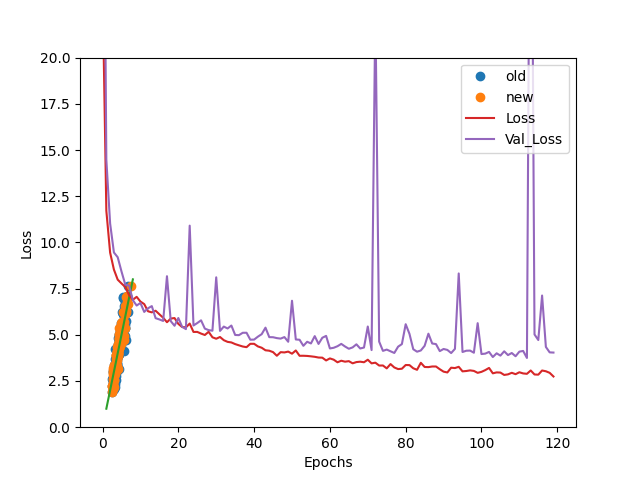

loss epoch plot execute!


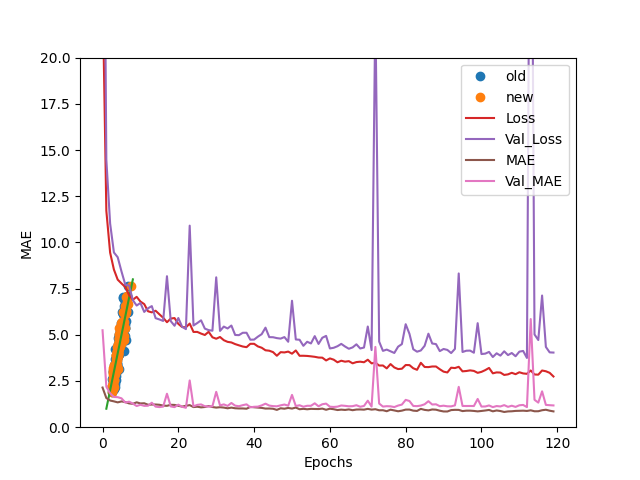

mae epoch plot execute!
9/9 [==============================] - 0s 17ms/step
coefficient of determination: 0.7099039440849779


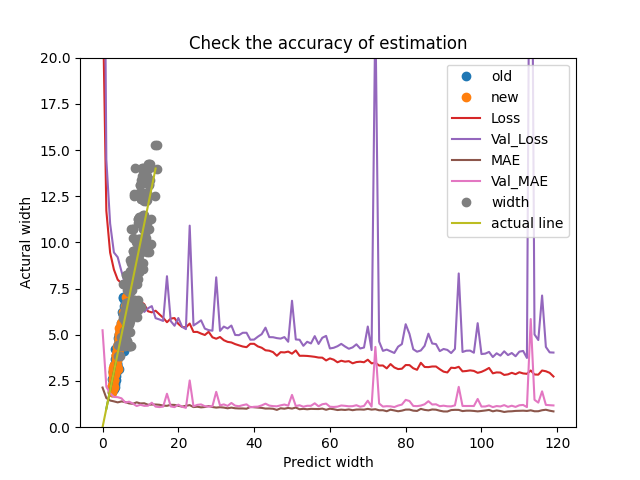

In [211]:
best_model, best_model_hp, history = hp_model_output_information(tuner_BO,X_train,y_train,X_test,y_test)

In [215]:
model_save_path = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models"
best_model.save(os.path.join(model_save_path,"bin2_BOGroundTruthML_10point_each_segment_best_model_val_version"))

2023-01-12 14:01:02,592-[WARNING]- absl:269 -> Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.
2023-01-12 14:01:03,876-[INFO]- tensorflow:779 -> Assets written to: /home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models/bin2_BOGroundTruthML_10point_each_segment_best_model_val_version/assets


In [216]:
def get_model(name):
    model_save = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models/"
    return os.path.join(model_save,name)
BO_ground = keras.models.load_model(get_model("bin2_BOGroundTruthML_10point_each_segment_best_model_val_version"))

9/9 [==============================] - 0s 17ms/step


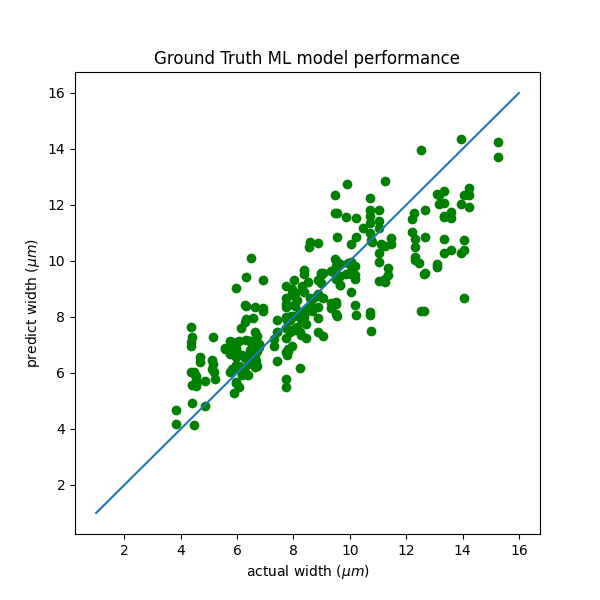

In [224]:
%matplotlib widget
predict_label = BO_ground.predict(X_test)
actual_label = y_test
plt.figure(figsize=(6, 6))
plt.plot(actual_label,predict_label,"og")
plt.plot([1,16],[1,16])
plt.xlabel("actual width ($\mu m$)")
plt.ylabel("predict width ($\mu m$)")
plt.title("Ground Truth ML model performance")
plt.savefig("plot_data/GroundTruthML/Ground Truth ML model performance.png")

In [260]:
collect_slice = []
collect_labels = []
order_label = ["order_1","order_2","order_3","order_4"]
for begin in range(len(selection_file)):
    file_name = selection_file[begin].split('/')[-1].split('.')[0]
    try:
        row = exp_df.loc[file_name].dropna()
        if len(row) <= 3:
            print(f'{file_name} is loading.')
            image = imageio.imread(selection_file[begin])
            segmented, nx_graph_pruned, pos = segment_brightfield(image)
            edges = list(nx_graph_pruned.edges)
            bound1 = 0
            bound2 = 1
            offset=100
            step=30
            target_length=200
            resolution = 1
            weight = 0.15
            count = -1
            for edge in edges:
                if count < 3:
                    count+=1
                try:
                    position = ML_df.loc[file_name][order_label[count]]
                    width = exp_df.loc[file_name][position]
                    slices, segments = extract_section_profiles_for_edge(
                        edge,
                        pos,
                        image,
                        nx_graph_pruned,
                        resolution=resolution,
                        offset=offset,
                        step=step,
                        target_length=target_length,
                        bound1=bound1,
                        bound2=bound2)
                    # for dataset                    
                    collect_slice.append(slices)
                    collect_labels.append(width)
                except KeyError:
                    print(f'{file_name} {order_label[count]} cannot find')
                    continue
    except KeyError:
        print(f'The file {file_name} will not be extract.')

The file pos01_focus1 will not be extract.
The file pos01_focus2 will not be extract.
The file pos01_focus3 will not be extract.
pos02 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos06 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos07 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos08 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos09 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos10 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos11 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos12 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos13 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos14 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos14 order_4 cannot find
pos15 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos16 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos17 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos19 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos22 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos24 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos25 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos28 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos29 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos29 order_4 cannot find
pos31 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos32 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos33 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos33 order_2 cannot find
pos36 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos37 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos38 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos38 order_1 cannot find
pos42 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos42 order_4 cannot find
pos45 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos46 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos46 order_4 cannot find
pos47 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos49 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos50 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos51 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos53 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos54 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos55 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos56 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos57 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos58 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos62 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos63 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos64 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


In [261]:
edge_width = []
for i in collect_slice:
    edge_width.append(BO_ground.predict(i))
collect_median = []
for i in range(len(edge_width)):
    collect_median.append(np.median(edge_width[i]))

26/26 [==============================] - 0s 18ms/step


In [265]:
collect_mean = []
for i in range(len(edge_width)):
    collect_mean.append(np.mean(edge_width[i]))
remove = []
for i in collect_mean:
    if i < 1e5:
        remove.append(i)
    else:
        remove.append(6)

In [301]:
import statistics
collect_mode = []
for i in range(len(edge_width)):
    collect_mode.append(statistics.mode(edge_width[i].reshape(-1).tolist()))
remove1 = []
for i in collect_mode:
    if i < 1e5:
        remove1.append(i)
    else:
        remove1.append(6)

In [262]:
collect_labels = np.array(collect_labels)*2

array([ 8.96292078,  9.70624938, 10.19345974, 10.23721113,  8.38277942,
        6.32680762,  8.11473701,  6.18693282, 10.38421064,  8.88120283,
        8.97495031,  4.66981602,  8.19033198,  5.62411571,  9.64742674,
       10.02960217,  5.97610921,  9.64339169, 10.80129285, 13.59074909,
        6.56759202, 11.23987503,  6.90486676, 13.95383549, 12.22478072,
       12.67833921,  5.73977948,  7.74206925, 13.16690705, 10.45719306,
       15.2750512 ,  4.39897804, 11.03551822, 11.03309566,  6.08597045,
       11.45949356,  6.13790655, 10.7196671 , 12.32239459, 10.73360167,
        7.91398691, 12.45905353, 13.08654019, 14.22067687,  6.5063986 ,
       11.3610771 ,  6.28359024,  9.89937903,  7.74640112, 12.64203262,
       13.3570783 ,  8.27955256,  4.36849128,  9.48570473,  8.24136329,
       12.51866351, 14.04389632,  5.58824119,  9.04979261, 12.28289798,
        6.68606784,  5.95423744,  9.51678788,  5.12913811,  6.72190372,
        8.61797981,  7.77905124,  5.12444931,  8.58271996,  6.46

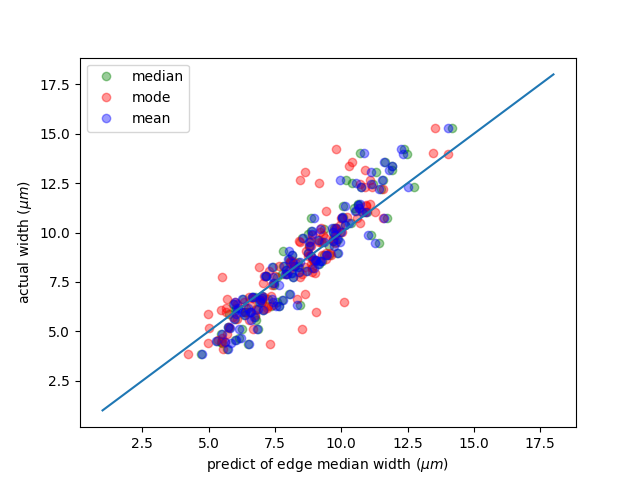

In [303]:
%matplotlib widget
plt.plot(collect_median ,collect_labels,"go",label="median",alpha=0.4)
plt.plot(remove1 ,collect_labels,"ro",label="mode",alpha=0.4)
plt.plot(remove,collect_labels,"bo",label="mean",alpha=0.4)
plt.xlabel("predict of edge median width ($\mu m$)")
plt.ylabel("actual width ($\mu m$)")
plt.legend()
plt.plot((1,18),(1,18))
# plt.savefig("plot_data/GroundTruthML/Ground Truth ML model median plot.png")

In [183]:
model_save_path = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models"
model_list = ["BOGroundTruthML_500step_best_model", 
              "BOGroundTruthML_500step_withoutcentral_best_model", 
              "BOGroundTruthML_1000step_best_model", 
              "BOGroundTruthML_1000step_withoutcentral_best_model",
              "BOGroundTruthML_10point_each_segment_best_model",
              "BOGroundTruthML_10point_each_segment_best_model_new"]
step_500 = keras.models.load_model(os.path.join(model_save_path,model_list[0]))
step_500_without = keras.models.load_model(os.path.join(model_save_path,model_list[1]))
step_1000 = keras.models.load_model(os.path.join(model_save_path,model_list[2]))
step_1000_without = keras.models.load_model(os.path.join(model_save_path,model_list[3]))
point_10 = keras.models.load_model(os.path.join(model_save_path,model_list[4]))
point_10_new = keras.models.load_model(os.path.join(model_save_path,model_list[5]))
BO_model = [step_500,step_500_without,step_1000,step_1000_without,point_10,point_10_new]
BO_label = ["step_500","step_500_without","step_1000","step_1000_without","10point_each_segment","10point_each_segment_new"]

In [184]:
X, y=data("50X_groundtruth_dataset")

In [185]:
BO_accuracy = []
for i in range(len(model_list)):
    BO_accuracy.append([])

In [186]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
n_iterations = 1000
for i in range(len(model_list)):
    for _ in range(n_iterations):
        X_bs, y_bs = resample(X, y, replace=True,n_samples=50)
        loss, acc = BO_model[i].evaluate(X_bs,y_bs,verbose=1)
        BO_accuracy[i].append(acc)

2/2 [==============================] - 0s 19ms/step - loss: 4.4933 - mean_absolute_error: 0.5003


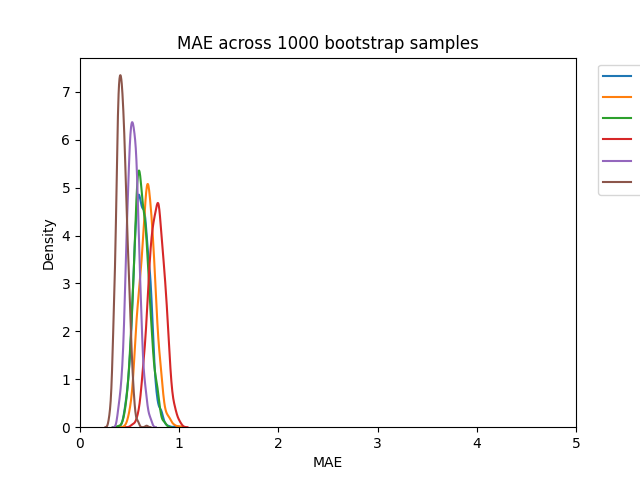

In [187]:
%matplotlib widget
import seaborn as sns
# plot distribution of accuracy
for i in range(len(BO_accuracy)):
    sns.kdeplot(BO_accuracy[i],label=BO_label[i])
plt.xlim(0,5)
plt.legend(bbox_to_anchor=(1.03, 1),loc='upper left')
plt.title("MAE across 1000 bootstrap samples")
plt.xlabel("MAE")
plt.savefig("plot_data/BootstrapingModelGroundTruth.png",bbox_inches="tight")

In [16]:
collect_slice = []
collect_labels = []
order_label = ["order_1","order_2","order_3","order_4"]
for begin in range(len(selection_file)):
    file_name = selection_file[begin].split('/')[-1].split('.')[0]
    try:
        row = exp_df.loc[file_name].dropna()
        if len(row) <= 3:
            print(f'{file_name} is loading.')
            image = imageio.imread(selection_file[begin])
            segmented, nx_graph_pruned, pos = segment_brightfield(image)
            edges = list(nx_graph_pruned.edges)
            bound1 = 0
            bound2 = 1
            offset=100
            step=30
            target_length=200
            resolution = 1
            weight = 0.15
            count = -1
            for edge in edges:
                if count < 3:
                    count+=1
                try:
                    position = ML_df.loc[file_name][order_label[count]]
                    width = exp_df.loc[file_name][position]
                    slices, segments = extract_section_profiles_for_edge(
                        edge,
                        pos,
                        image,
                        nx_graph_pruned,
                        resolution=resolution,
                        offset=offset,
                        step=step,
                        target_length=target_length,
                        bound1=bound1,
                        bound2=bound2)
                    # for dataset                    
                    collect_slice.append(slices)
                    collect_labels.append(width)
                except KeyError:
                    print(f'{file_name} {order_label[count]} cannot find')
                    continue
    except KeyError:
        print(f'The file {file_name} will not be extract.')

The file pos01_focus1 will not be extract.
The file pos01_focus2 will not be extract.
The file pos01_focus3 will not be extract.
pos02 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos06 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos07 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos08 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos09 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos10 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos11 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos12 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos13 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos14 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos14 order_4 cannot find
pos15 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos16 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos17 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos19 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos22 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos24 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos25 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos28 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos29 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos29 order_4 cannot find
pos31 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos32 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos33 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos33 order_2 cannot find
pos36 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos37 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos38 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos38 order_1 cannot find
pos42 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos42 order_4 cannot find
pos45 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos46 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos46 order_4 cannot find
pos47 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos49 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos50 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos51 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos53 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos54 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos55 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos56 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos57 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos58 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos58 order_4 cannot find
pos62 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos63 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


pos64 is loading.


/home/ipausers/lin/Desktop/AMF/AMFtrack/amftrack/pipeline/functions/image_processing/extract_graph.py:170: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(pd.DataFrame(edges[branch]), ignore_index=True)


13/13 [==============================] - 0s 26ms/step


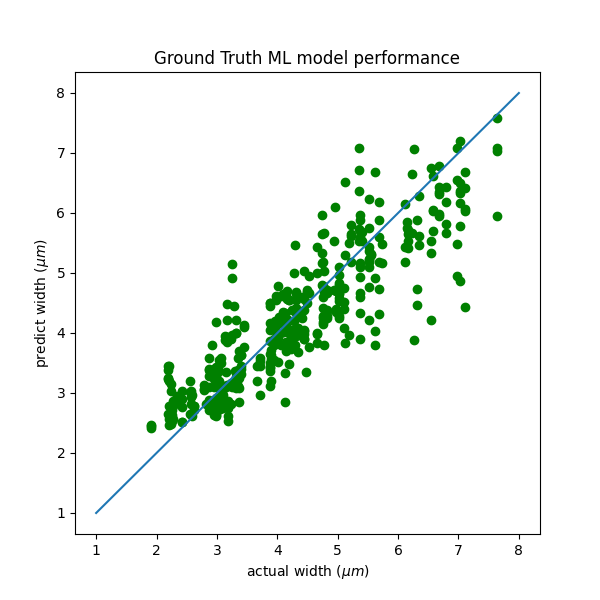

In [200]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
predict_label = point_10_new.predict(X_test)
actual_label = y_test
plt.figure(figsize=(6, 6))
plt.plot(actual_label,predict_label,"og")
# predict_label = point_10.predict(X_test)
# actual_label = y_test
# plt.plot(actual_label,predict_label,"or",label="old")
plt.plot([1,8],[1,8])
plt.xlabel("actual width ($\mu m$)")
plt.ylabel("predict width ($\mu m$)")
plt.title("Ground Truth ML model performance")
# plt.legend()
plt.savefig("plot_data/GroundTruthML/Ground Truth ML model performance.png")

In [118]:
len(collect_slice), len(collect_labels)

(121, 121)

In [193]:
edge_width_old = []
edge_width_new = []
for i in collect_slice:
    edge_width_old.append(point_10.predict(i))
    edge_width_new.append(point_10_new.predict(i))

26/26 [==============================] - 1s 26ms/step


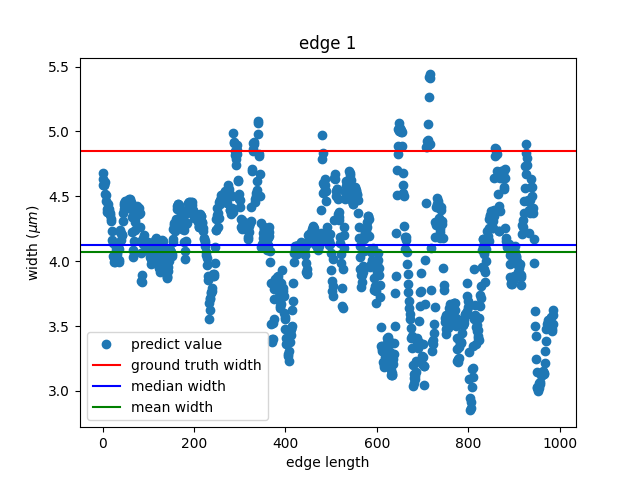

In [180]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
for i in [1]:
    plt.plot(np.arange(len(edge_width[i])),edge_width[i],"o",label="predict value")
    plt.axhline(y =collect_labels[i], color = 'r', linestyle = '-',label="ground truth width")
    plt.axhline(y =np.median(edge_width[i]), color = 'b', linestyle = '-',label="median width")
    plt.axhline(y =np.mean(edge_width[i]), color = 'g', linestyle = '-',label="mean width")
    plt.xlabel("edge length")
    plt.ylabel("width ($\mu m$)")
    plt.legend()
    plt.title(f'edge {i}')
    

In [194]:
collect_median_old = []
collect_median_new = []
for i in range(len(edge_width)):
    collect_median_old.append(np.median(edge_width_old[i]))
    collect_median_new.append(np.median(edge_width_new[i]))

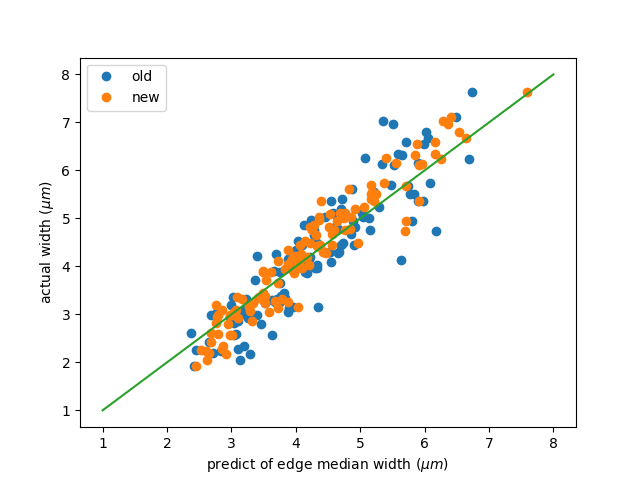

In [225]:
%matplotlib widget
plt.plot(collect_median_old ,collect_labels,"o",label="old")
plt.plot(collect_median_new ,collect_labels,"o",label="new")
# plt.plot(collect_median_new ,collect_labels,"o")
plt.xlabel("predict of edge median width ($\mu m$)")
plt.ylabel("actual width ($\mu m$)")
plt.plot((1,8),(1,8))
plt.legend()
plt.show()
# plt.savefig("plot_data/GroundTruthML/Ground Truth ML model median plot.png")